Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [92]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [93]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [94]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [95]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [96]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [97]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [98]:
region = 'global'
crop = 'Maize'
if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [99]:
cmip6_tasmax_grow_max = xr.Dataset()
cmip6_tasmax_grow_mean = xr.Dataset()
cmip6_ef_grow = xr.Dataset()
cmip6_mrso_grow = xr.Dataset()
cmip6_pr_grow = xr.Dataset()
cmip6_tran_grow = xr.Dataset()
cmip6_cropFrac_grow = xr.Dataset()

ef_m = 0
mrso_m = 0
pr_m = 0
tran_m = 0
cropFrac_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
#     print('loading regridded growing season tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max = ds_global_txx
        cmip6_tasmax_grow_mean = ds_global_t50p
    else:
        cmip6_tasmax_grow_max = xr.concat([cmip6_tasmax_grow_max, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean = xr.concat([cmip6_tasmax_grow_mean, ds_global_t50p], dim='model')
    
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow = ds_global_ef
        else:
            cmip6_ef_grow = xr.concat([cmip6_ef_grow, ds_global_ef], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_mrso = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model))
        
        if mrso_m == 0:
            cmip6_mrso_grow = ds_global_mrso
        else:
            cmip6_mrso_grow = xr.concat([cmip6_mrso_grow, ds_global_mrso], dim='model')
        mrso_m += 1
    else:
        print('skipping mrso %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model)):
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow = ds_global_pr
        else:
            cmip6_pr_grow = xr.concat([cmip6_pr_grow, ds_global_pr], dim='model')
        pr_m += 1
    else:
        print('skipping pr %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model))
        
        if tran_m == 0:
            cmip6_tran_grow = ds_global_tran
        else:
            cmip6_tran_grow = xr.concat([cmip6_tran_grow, ds_global_tran], dim='model')
        tran_m += 1
    else:
        print('skipping tran %s'%model)
    
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model))
        
        if cropFrac_m == 0:
            cmip6_cropFrac_grow = ds_global_cropFrac
        else:
            cmip6_cropFrac_grow = xr.concat([cmip6_cropFrac_grow, ds_global_cropFrac], dim='model')
        cropFrac_m += 1
    else:
        print('skipping cropFrac %s'%model)


skipping tran access-cm2
skipping tran access-esm1-5
skipping mrso awi-cm-1-1-mr
skipping pr awi-cm-1-1-mr
skipping tran awi-cm-1-1-mr
skipping cropFrac awi-cm-1-1-mr
skipping pr bcc-csm2-mr
skipping cropFrac bcc-csm2-mr
skipping cropFrac bcc-esm1
skipping tran ec-earth3
skipping cropFrac ec-earth3
skipping ef gfdl-cm4
skipping pr gfdl-cm4
skipping ef gfdl-esm4
skipping mrso giss-e2-1-g
skipping pr giss-e2-1-g
skipping cropFrac giss-e2-1-g
skipping ef kace-1-0-g
skipping mrso kace-1-0-g
skipping tran kace-1-0-g
skipping cropFrac kace-1-0-g
skipping cropFrac fgoals-g3
skipping tran inm-cm5-0
skipping cropFrac miroc6
skipping tran mpi-esm1-2-hr
skipping tran mpi-esm1-2-lr
skipping cropFrac mri-esm2-0
skipping cropFrac noresm2-lm
skipping pr noresm2-mm
skipping cropFrac noresm2-mm
skipping ef sam0-unicon
skipping mrso sam0-unicon
skipping pr sam0-unicon
skipping tran sam0-unicon
skipping cropFrac sam0-unicon


In [100]:
cmip6_tasmax_grow_max_trend = xr.Dataset()
cmip6_tasmax_grow_mean_trend = xr.Dataset()
cmip6_ef_grow_trend = xr.Dataset()

ef_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading growing season trends for %s'%model)

    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow_trend = ds_global_ef_trend
        else:
            cmip6_ef_grow_trend = xr.concat([cmip6_ef_grow_trend, ds_global_ef_trend], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
    
    ds_global_txx_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_mean_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))

    if m == 0:
        cmip6_tasmax_grow_max_trend = ds_global_txx_trend
        cmip6_tasmax_grow_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmax_grow_max_trend = xr.concat([cmip6_tasmax_grow_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmax_grow_mean_trend = xr.concat([cmip6_tasmax_grow_mean_trend, ds_global_t50p_trend], dim='model')

# cmip6_tasmax_max_trend = cmip6_tasmax_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_monthly_max_trend = cmip6_tasmax_monthly_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_mean_trend = cmip6_tasmax_mean_trend.assign_coords({'model':cmip6_models})


loading growing season trends for access-cm2
loading growing season trends for access-esm1-5
loading growing season trends for awi-cm-1-1-mr
loading growing season trends for bcc-csm2-mr
loading growing season trends for bcc-esm1
loading growing season trends for canesm5
loading growing season trends for ec-earth3
loading growing season trends for gfdl-cm4
skipping ef gfdl-cm4
loading growing season trends for gfdl-esm4
skipping ef gfdl-esm4
loading growing season trends for giss-e2-1-g
loading growing season trends for kace-1-0-g
skipping ef kace-1-0-g
loading growing season trends for fgoals-g3
loading growing season trends for inm-cm5-0
loading growing season trends for ipsl-cm6a-lr
loading growing season trends for miroc6
loading growing season trends for mpi-esm1-2-hr
loading growing season trends for mpi-esm1-2-lr
loading growing season trends for mri-esm2-0
loading growing season trends for noresm2-lm
loading growing season trends for noresm2-mm
loading growing season trends for

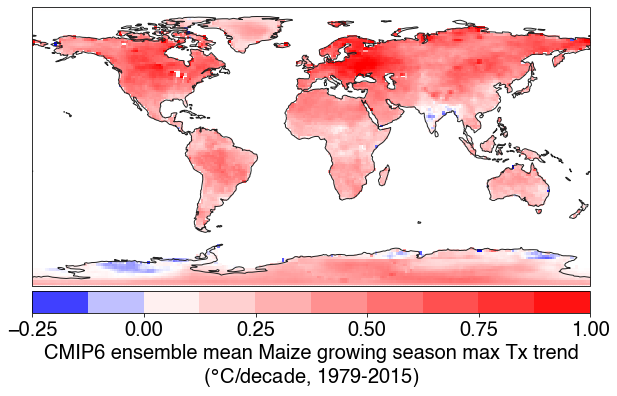

In [101]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

disp_lat = cmip6_tasmax_grow_max_trend.lat.values.copy()
disp_lon = cmip6_tasmax_grow_max_trend.lon.values.copy()       
disp_data = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.mean(dim='model').values.copy()
# disp_data = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values.copy()

# disp_data, disp_lon = cartopy.util.add_cyclic_point(disp_data, coord=disp_lon)

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm)
# c = plt.contourf(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble mean Maize growing season max Tx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

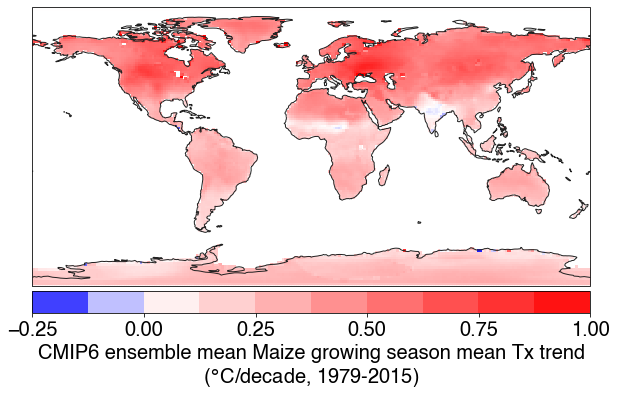

In [102]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.pcolormesh(cmip6_tasmax_grow_mean_trend.lon, cmip6_tasmax_grow_mean_trend.lat, cmip6_tasmax_grow_mean_trend.tasmax_grow_mean_trend.mean(dim='model').values, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(cmip6_tasmax_mean_trend.lon, cmip6_tasmax_mean_trend.lat, cmip6_tasmax_mean_trend.tasmax_mean_trend.mean(dim='model').values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))


if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble mean Maize growing season mean Tx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

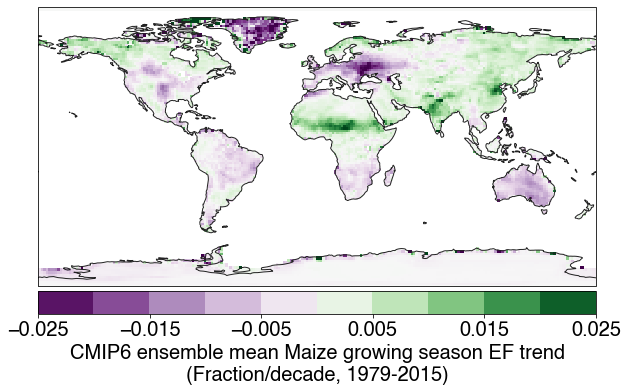

In [103]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -.025
v2 = .0251
vstep = .005
vlabelstep = .01

disp_lat = cmip6_ef_grow_trend.lat.values.copy()
disp_lon = cmip6_ef_grow_trend.lon.values.copy()       
disp_data = cmip6_ef_grow_trend.grow_ef.mean(dim='model').values.copy()
# disp_data = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values.copy()

# disp_data, disp_lon = cartopy.util.add_cyclic_point(disp_data, coord=disp_lon)

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')

c = plt.pcolormesh(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm)
# c = plt.contourf(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble mean Maize growing season EF trend\n(Fraction/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [104]:
# load era5 growing season temps

era5_tasmax_grow_max_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s.nc'%(crop,region))
era5_tasmax_grow_mean_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_mean_regrid_%s.nc'%(crop,region))
era5_ef_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_ef_grow_regrid_%s.nc'%(crop,region))
era5_pr_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_regrid_%s.nc'%(crop,region))
era5_tran_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_trans_grow_regrid_%s.nc'%(crop,region))


In [105]:
%%time

# era5 trends for growing season data
era5_tasmax_grow_max_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_max_trend_%s.nc'%region)
era5_tasmax_grow_mean_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_mean_trend_%s.nc'%region)    
era5_ef_grow_trend = xr.open_dataset('era5/growing_season/era5_ef_grow_trend_%s.nc'%region)


CPU times: user 5.62 ms, sys: 657 µs, total: 6.28 ms
Wall time: 5.98 ms


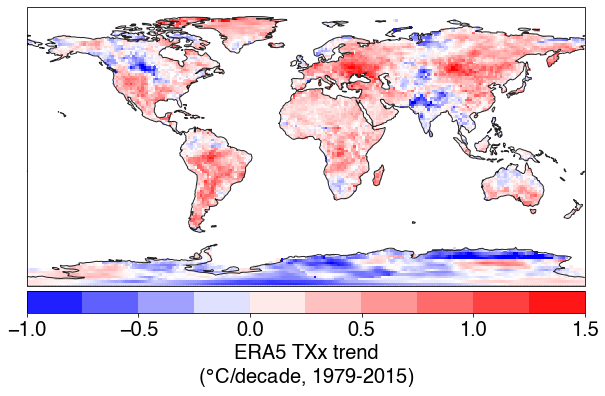

In [106]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, era5_tasmax_grow_max_trend.tasmax_grow_max_trend.values, cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, era5_tasmax_max_trend.tasmax_max_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

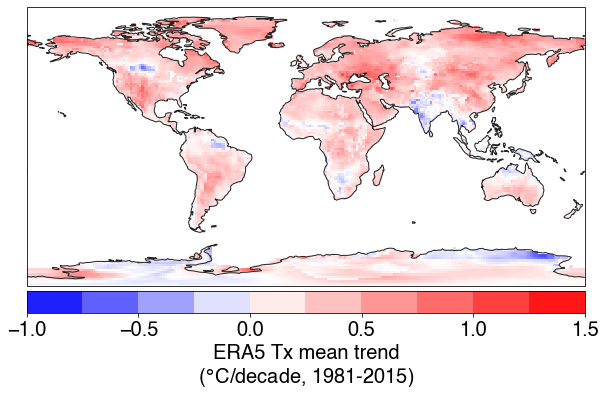

In [107]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.pcolormesh(era5_tasmax_grow_mean_trend.lon, era5_tasmax_grow_mean_trend.lat, era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.values, cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 Tx mean trend\n($\degree$C/decade, 1981-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

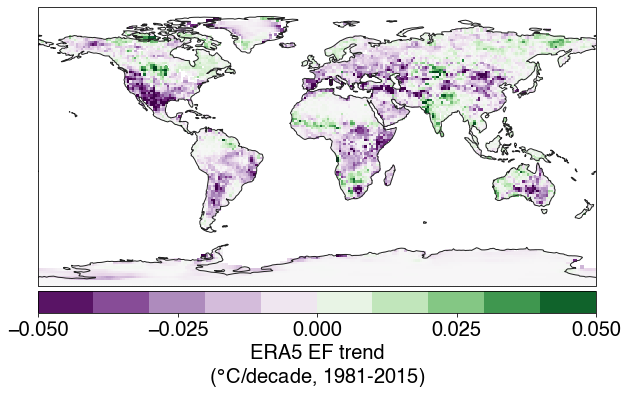

In [108]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -.05
v2 = .051
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')
c = plt.pcolormesh(era5_ef_grow_trend.lon, era5_ef_grow_trend.lat, era5_ef_grow_trend.ef_grow_trend.values, cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 EF trend\n($\degree$C/decade, 1981-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [109]:
# load pre-calculated bias by year

monthly_groups = cmip6_tasmax_monthly_max.groupby('time.month').groups


yearly_tasmax_grow_max_bias = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_grow_mean_bias = np.full([len(cmip6_models), era5_tasmax_grow_mean_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_mean_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_mean_regrid.lon.values.shape[0]], np.nan)
yearly_ef_grow_bias = np.full([len(cmip6_models), era5_ef_grow_regrid.time.values.shape[0], \
                                   era5_ef_grow_regrid.lat.values.shape[0], \
                                   era5_ef_grow_regrid.lon.values.shape[0]], np.nan)

yearly_pr_grow_bias = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
yearly_pr_grow_bias_rel = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)

yearly_tran_grow_bias = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)
yearly_tran_grow_bias_rel = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)

for m, model in enumerate(cmip6_models):
    print('loading yearly bias for %s'%model)

    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_max_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-mean-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_mean_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_ef_grow_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_pr_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_pr_grow_bias.shape[1]):
                yearly_pr_grow_bias_rel[m, y, :, :] = yearly_pr_grow_bias[m, y, :, :]/np.nanmean(era5_pr_grow_regrid.pr_grow_mean, axis=0)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-tran-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-tran-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_tran_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_tran_grow_bias.shape[1]):
                yearly_tran_grow_bias_rel[m, y, :, :] = yearly_tran_grow_bias[m, y, :, :]/-np.nanmean(era5_tran_grow_regrid.trans_grow_mean, axis=0)
        


loading yearly bias for access-cm2
loading yearly bias for access-esm1-5
loading yearly bias for awi-cm-1-1-mr
loading yearly bias for bcc-csm2-mr
loading yearly bias for bcc-esm1
loading yearly bias for canesm5
loading yearly bias for ec-earth3
loading yearly bias for gfdl-cm4
loading yearly bias for gfdl-esm4
loading yearly bias for giss-e2-1-g
loading yearly bias for kace-1-0-g
loading yearly bias for fgoals-g3
loading yearly bias for inm-cm5-0
loading yearly bias for ipsl-cm6a-lr
loading yearly bias for miroc6
loading yearly bias for mpi-esm1-2-hr
loading yearly bias for mpi-esm1-2-lr
loading yearly bias for mri-esm2-0
loading yearly bias for noresm2-lm
loading yearly bias for noresm2-mm
loading yearly bias for sam0-unicon


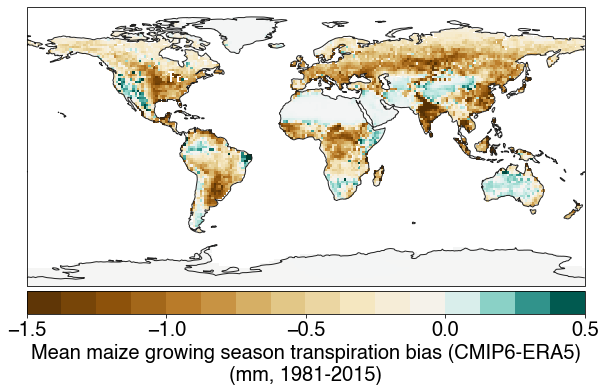

In [110]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -1.5
v2 = 0.51
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, np.nanmean(np.nanmean(yearly_tran_grow_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean maize growing season transpiration bias (CMIP6-ERA5)\n(mm, 1981-2015)', fontsize=20)

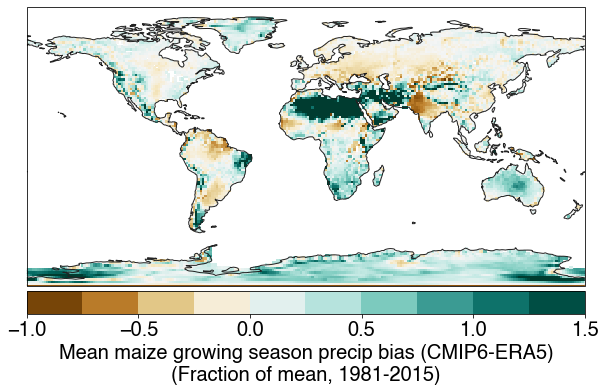

In [111]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(np.nanmean(yearly_pr_grow_bias_rel, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean maize growing season precip bias (CMIP6-ERA5)\n(Fraction of mean, 1981-2015)', fontsize=20)

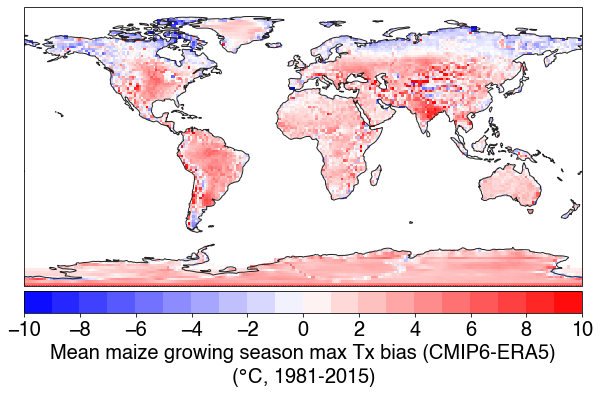

In [112]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -10
v2 = 10.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean maize growing season max Tx bias (CMIP6-ERA5)\n($\degree$C, 1981-2015)', fontsize=20)

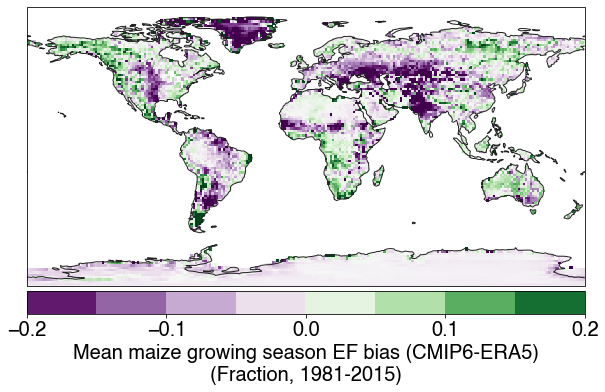

In [113]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -.2
v2 = .21
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmedian(np.nanmean(yearly_ef_grow_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean maize growing season EF bias (CMIP6-ERA5)\n(Fraction, 1981-2015)', fontsize=20)

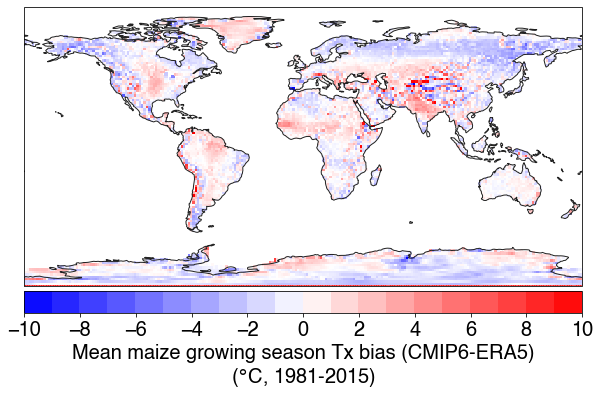

In [114]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -10
v2 = 10.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
                 np.nanmedian(np.nanmean(yearly_tasmax_grow_mean_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)

# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_mean_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, yearly_txx_bias_trend_sig, levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean maize growing season Tx bias (CMIP6-ERA5)\n($\degree$C, 1981-2015)', fontsize=20)

In [115]:

yearly_tasmax_grow_max_bias_trend = np.full([len(cmip6_models), yearly_tasmax_grow_max_bias.shape[2], yearly_tasmax_grow_max_bias.shape[3]], np.nan)
yearly_tasmax_grow_max_bias_trend_sig = np.full([len(cmip6_models), yearly_tasmax_grow_max_bias.shape[2], yearly_tasmax_grow_max_bias.shape[3]], np.nan)

yearly_tasmax_grow_mean_bias_trend = np.full([len(cmip6_models), yearly_tasmax_grow_mean_bias.shape[2], yearly_tasmax_grow_mean_bias.shape[3]], np.nan)
yearly_tasmax_grow_mean_bias_trend_sig = np.full([len(cmip6_models), yearly_tasmax_grow_mean_bias.shape[2], yearly_tasmax_grow_mean_bias.shape[3]], np.nan)

yearly_ef_grow_bias_trend = np.full([len(cmip6_models), yearly_ef_grow_bias.shape[2], yearly_ef_grow_bias.shape[3]], np.nan)
yearly_ef_grow_bias_trend_sig = np.full([len(cmip6_models), yearly_ef_grow_bias.shape[2], yearly_ef_grow_bias.shape[3]], np.nan)

for m, model in enumerate(cmip6_models):
    print('loading precomputed bias trend for %s...'%model)

        
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-bias-trend-%s-%s.dat'%(region, model), 'rb') as f:
        f = pickle.load(f)
        yearly_tasmax_grow_max_bias_trend[m,:,:] = f['yearly_tasmax_grow_max_bias_trend']
        yearly_tasmax_grow_max_bias_trend_sig[m,:,:] = f['yearly_tasmax_grow_max_bias_trend_sig']

        yearly_tasmax_grow_mean_bias_trend[m,:,:] = f['yearly_tasmax_grow_mean_bias_trend']
        yearly_tasmax_grow_mean_bias_trend_sig[m,:,:] = f['yearly_tasmax_grow_mean_bias_trend_sig']
        
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-trend-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-trend-%s-%s.dat'%(region, model), 'rb') as f:
            f = pickle.load(f)
            yearly_ef_grow_bias_trend[m,:,:] = f['yearly_ef_grow_bias_trend']
            yearly_ef_grow_bias_trend_sig[m,:,:] = f['yearly_ef_grow_bias_trend_sig']
        
        



loading precomputed bias trend for access-cm2...
loading precomputed bias trend for access-esm1-5...
loading precomputed bias trend for awi-cm-1-1-mr...
loading precomputed bias trend for bcc-csm2-mr...
loading precomputed bias trend for bcc-esm1...
loading precomputed bias trend for canesm5...
loading precomputed bias trend for ec-earth3...
loading precomputed bias trend for gfdl-cm4...
loading precomputed bias trend for gfdl-esm4...
loading precomputed bias trend for giss-e2-1-g...
loading precomputed bias trend for kace-1-0-g...
loading precomputed bias trend for fgoals-g3...
loading precomputed bias trend for inm-cm5-0...
loading precomputed bias trend for ipsl-cm6a-lr...
loading precomputed bias trend for miroc6...
loading precomputed bias trend for mpi-esm1-2-hr...
loading precomputed bias trend for mpi-esm1-2-lr...
loading precomputed bias trend for mri-esm2-0...
loading precomputed bias trend for noresm2-lm...
loading precomputed bias trend for noresm2-mm...
loading precomputed

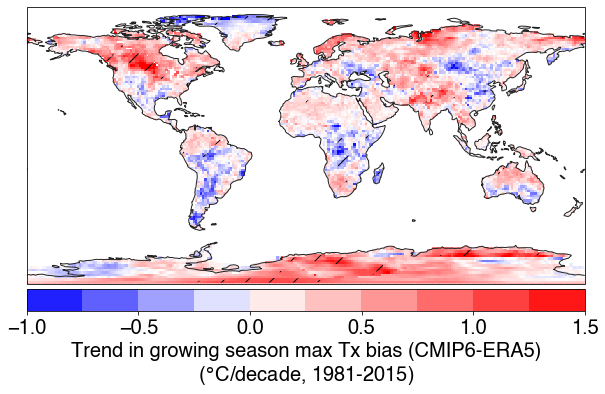

In [116]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
                 np.nanmean(yearly_tasmax_grow_max_bias_trend, axis=0), cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(yearly_tasmax_max_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
             np.nanmedian(yearly_tasmax_grow_max_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in growing season max Tx bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

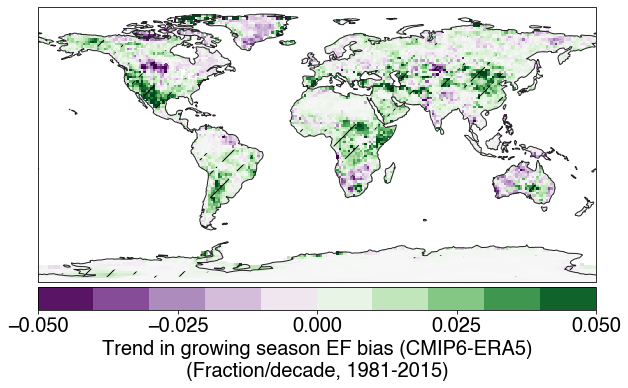

In [117]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -.05
v2 = .051
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(yearly_ef_grow_bias_trend, axis=0), cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(yearly_tasmax_max_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

plt.contourf(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
             np.nanmedian(yearly_ef_grow_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in growing season EF bias (CMIP6-ERA5)\n(Fraction/decade, 1981-2015)', fontsize=20)

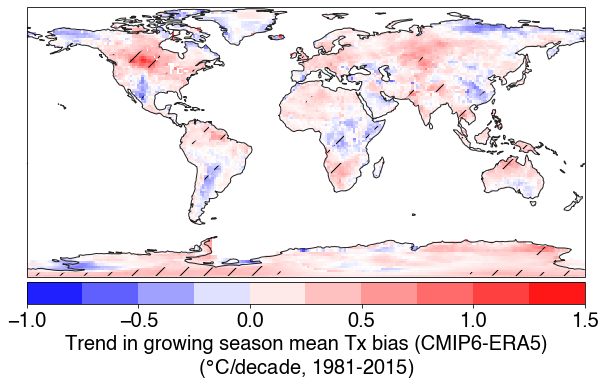

In [118]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
                 np.nanmedian(yearly_tasmax_grow_mean_bias_trend, axis=0), cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
#                  np.nanmedian(yearly_tasmax_mean_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
             np.nanmedian(yearly_tasmax_grow_mean_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in growing season mean Tx bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [120]:
regridMesh['lat'].size

120

In [121]:
# load cropped area data
print('loading regridded ha')
with open('cropped_area/maize_ha_regrid_%d_%d.dat'%(regridMesh['lat'].size, regridMesh['lon'].size), 'rb') as f:
    maize_ha_regrid_15 = pickle.load(f)
with open('cropped_area/soy_ha_regrid_%d_%d.dat'%(regridMesh['lat'].size, regridMesh['lon'].size), 'rb') as f:
    soy_ha_regrid_15 = pickle.load(f)
with open('cropped_area/wheat_ha_regrid_%d_%d.dat'%(regridMesh['lat'].size, regridMesh['lon'].size), 'rb') as f:
    wheat_ha_regrid_15 = pickle.load(f)
with open('cropped_area/rice_ha_regrid_%d_%d.dat'%(regridMesh['lat'].size, regridMesh['lon'].size), 'rb') as f:
    rice_ha_regrid_15 = pickle.load(f)


loading regridded ha


In [122]:
crop_ha_regrid_15 = np.full(maize_ha_regrid_15[0,:,:].shape, np.nan)
crop_all_ha_regrid_15 = np.full(maize_ha_regrid_15[0,:,:].shape, np.nan)
crop_ha_chg_regrid_15 = np.full(maize_ha_regrid_15[0,:,:].shape, np.nan)

for xlat in range(crop_ha_regrid_15.shape[0]):
    for ylon in range(crop_ha_regrid_15.shape[1]):
        
#         tmp1 = np.nansum([maize_ha_regrid_15[0, xlat, ylon], soy_ha_regrid_15[0, xlat, ylon], wheat_ha_regrid_15[0, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
#         tmp2 = np.nansum([maize_ha_regrid_15[-1, xlat, ylon], soy_ha_regrid_15[-1, xlat, ylon], wheat_ha_regrid_15[-1, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
        
#         tmp1 = np.nansum([maize_ha_regrid_15[0, xlat, ylon], soy_ha_regrid_15[0, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
#         tmp2 = np.nansum([maize_ha_regrid_15[-1, xlat, ylon], soy_ha_regrid_15[-1, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
        
        tmp1 = maize_ha_regrid_15[0, xlat, ylon]
        tmp2 = maize_ha_regrid_15[-1, xlat, ylon]
        tmp_all = np.nansum([maize_ha_regrid_15[-1, xlat, ylon], soy_ha_regrid_15[-1, xlat, ylon], wheat_ha_regrid_15[-1, xlat, ylon], rice_ha_regrid_15[-1, xlat, ylon]])
        
        tmp_chg = tmp2 - tmp1
        
        if tmp2 > 0:
            crop_ha_regrid_15[xlat, ylon] = tmp2
            crop_ha_chg_regrid_15[xlat, ylon] = tmp_chg
        
        crop_all_ha_regrid_15[xlat, ylon] = tmp_all
            


In [123]:
crop_ha_regrid_15_1d = np.reshape(crop_ha_regrid_15, [crop_ha_regrid_15.size,1])
crop_all_ha_regrid_15_1d = np.reshape(crop_all_ha_regrid_15, [crop_all_ha_regrid_15.size,1])
crop_ha_chg_regrid_15_1d = np.reshape(crop_ha_chg_regrid_15, [crop_ha_chg_regrid_15.size,1])

In [124]:
%%time
if not os.path.isfile('irrigation_data_regrid_120_240.dat'):
    faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
    irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
    irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
    irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
    irrigationLon[irrigationLon<0] += 360

    regridder = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear')
    irrigation_data_regrid = regridder(irrigationData)

    with open('irrigation_data_regrid_120_240.dat', 'wb') as f:
        pickle.dump(irrigation_data_regrid, f)
else:
    with open('irrigation_data_regrid_120_240.dat', 'rb') as f:
        irrigation_data_regrid = pickle.load(f)

CPU times: user 1.21 ms, sys: 437 µs, total: 1.64 ms
Wall time: 43 ms


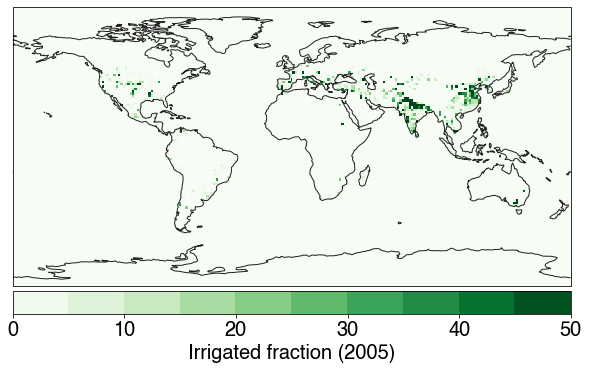

In [125]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
    
v1 = 0
v2 = 50.01
vstep = 5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], irrigation_data_regrid, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Irrigated fraction (2005)', fontsize=20)

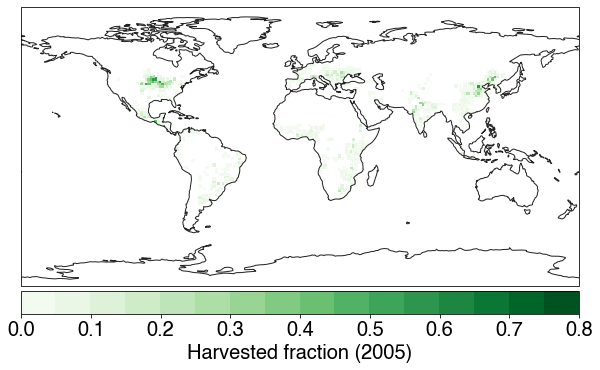

In [126]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ha_data = crop_ha_regrid_15.copy()
ha_data[ha_data<.01]=np.nan
    
v1 = 0
v2 = .81
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, ha_data, cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Harvested fraction (2005)', fontsize=20)

In [127]:
cmip6_ha_bias = np.full([len(cmip6_models), cmip6_cropFrac_grow.lat.size, cmip6_cropFrac_grow.lon.size], np.nan)

cmip6_cropFrac_grow_mean = cmip6_cropFrac_grow.grow_cropFrac.mean(dim='time').values

m_rel = 0
for m in range(len(cmip6_models)):
    if cmip6_models[m] in cmip6_cropFrac_grow.model.values:
        print('processing model %s'%cmip6_cropFrac_grow.model[m_rel])
        for xlat in range(cmip6_ha_bias.shape[1]):
            for ylon in range(cmip6_ha_bias.shape[2]):
                cmip6_ha_bias[m_rel, xlat, ylon] = cmip6_cropFrac_grow_mean[m_rel, xlat, ylon]-crop_all_ha_regrid_15[xlat, ylon]*100
        m_rel += 1

processing model <xarray.DataArray 'model' ()>
array('access-cm2', dtype='<U10')
Coordinates:
    model    <U10 'access-cm2'
processing model <xarray.DataArray 'model' ()>
array('access-esm1-5', dtype='<U13')
Coordinates:
    model    <U13 'access-esm1-5'
processing model <xarray.DataArray 'model' ()>
array('canesm5', dtype='<U7')
Coordinates:
    model    <U7 'canesm5'
processing model <xarray.DataArray 'model' ()>
array('gfdl-cm4', dtype='<U8')
Coordinates:
    model    <U8 'gfdl-cm4'
processing model <xarray.DataArray 'model' ()>
array('gfdl-esm4', dtype='<U9')
Coordinates:
    model    <U9 'gfdl-esm4'
processing model <xarray.DataArray 'model' ()>
array('inm-cm5-0', dtype='<U9')
Coordinates:
    model    <U9 'inm-cm5-0'
processing model <xarray.DataArray 'model' ()>
array('ipsl-cm6a-lr', dtype='<U12')
Coordinates:
    model    <U12 'ipsl-cm6a-lr'
processing model <xarray.DataArray 'model' ()>
array('mpi-esm1-2-hr', dtype='<U13')
Coordinates:
    model    <U13 'mpi-esm1-2-hr'
proces

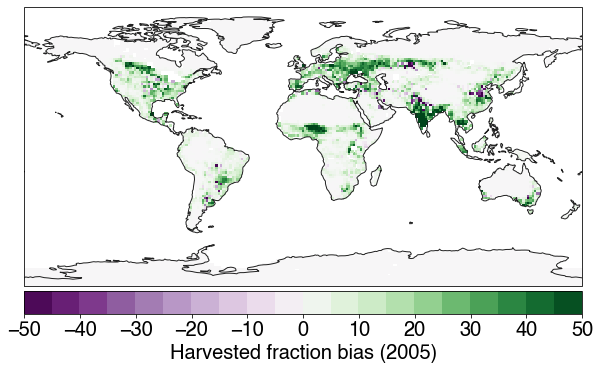

In [128]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ha_model = cmip6_cropFrac_grow.mean(dim='time').grow_cropFrac.values[7,:,:]
    
v1 = -50
v2 = 50.1
vstep = 5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')
c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, ha_model-crop_all_ha_regrid_15*100, cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Harvested fraction bias (2005)', fontsize=20)

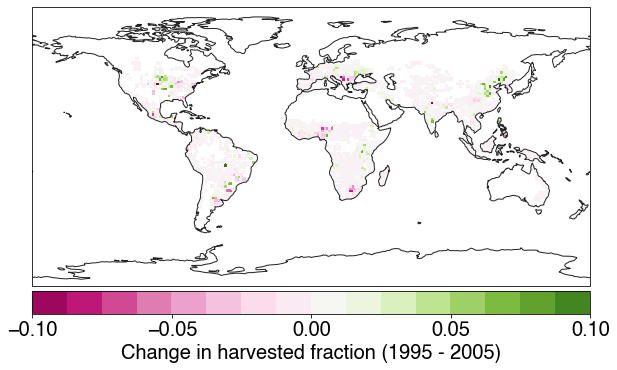

In [129]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -.1
v2 = .11
vstep = .0125
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('PiYG')
c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, crop_ha_chg_regrid_15, cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in harvested fraction (1995 - 2005)', fontsize=20)

In [130]:
# load deepak data
maize_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_maize_%s.nc'%region)
soy_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_soy_%s.nc'%region)
wheat_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_wheat_%s.nc'%region)

In [131]:
maize_yield_deepak_trend = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)
maize_yield_deepak_mean = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)

soy_yield_deepak_trend = np.full([soy_yield_deepak_ds.lat.values.size, soy_yield_deepak_ds.lon.values.size], np.nan)
soy_yield_deepak_mean = np.full([soy_yield_deepak_ds.lat.values.size, soy_yield_deepak_ds.lon.values.size], np.nan)

wheat_yield_deepak_trend = np.full([wheat_yield_deepak_ds.lat.values.size, wheat_yield_deepak_ds.lon.values.size], np.nan)
wheat_yield_deepak_mean = np.full([wheat_yield_deepak_ds.lat.values.size, wheat_yield_deepak_ds.lon.values.size], np.nan)

for xlat in range(maize_yield_deepak_trend.shape[0]):
    for ylon in range(maize_yield_deepak_trend.shape[1]):
        
        maize_yield_deepak_mean[xlat, ylon] = np.nanmean(maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon], axis=0)
        soy_yield_deepak_mean[xlat, ylon] = np.nanmean(soy_yield_deepak_ds.soy_yield.values[:, xlat, ylon], axis=0)
        
        curY = maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon]
        nn = np.where((~np.isnan(curY)))[0]
        if len(nn) > 20:
            X = sm.add_constant(range(len(nn)))
            mdl = sm.OLS(curY[nn], X).fit()
            maize_yield_deepak_trend[xlat, ylon] = mdl.params[1]
            
        curY = soy_yield_deepak_ds.soy_yield.values[:, xlat, ylon]
        nn = np.where((~np.isnan(curY)))[0]
        if len(nn) > 20:
            X = sm.add_constant(range(len(nn)))
            mdl = sm.OLS(curY[nn], X).fit()
            soy_yield_deepak_trend[xlat, ylon] = mdl.params[1]
            
        curY = wheat_yield_deepak_ds.wheat_yield.values[:, xlat, ylon]
        nn = np.where((~np.isnan(curY)))[0]
        if len(nn) > 20:
            X = sm.add_constant(range(len(nn)))
            mdl = sm.OLS(curY[nn], X).fit()
            wheat_yield_deepak_trend[xlat, ylon] = mdl.params[1]

maize_yield_deepak_trend_1d = np.reshape(maize_yield_deepak_trend, [maize_yield_deepak_trend.size, 1])
maize_yield_deepak_mean_1d = np.reshape(maize_yield_deepak_mean, [maize_yield_deepak_mean.size, 1])

soy_yield_deepak_trend_1d = np.reshape(soy_yield_deepak_trend, [soy_yield_deepak_trend.size, 1])
soy_yield_deepak_mean_1d = np.reshape(soy_yield_deepak_mean, [soy_yield_deepak_mean.size, 1])

wheat_yield_deepak_trend_1d = np.reshape(wheat_yield_deepak_trend, [wheat_yield_deepak_trend.size, 1])
wheat_yield_deepak_mean_1d = np.reshape(wheat_yield_deepak_mean, [wheat_yield_deepak_mean.size, 1])

prod_trend = maize_yield_deepak_trend*maize_ha_regrid_15[-1,:,:] #+ soy_yield_deepak_trend*soy_ha_regrid_15[-1,:,:] + wheat_yield_deepak_trend*wheat_ha_regrid_15[-1,:,:]
prod_trend_1d = np.reshape(prod_trend, [prod_trend.size, 1])

prod_mean = maize_yield_deepak_mean*maize_ha_regrid_15[-1,:,:] #+ soy_yield_deepak_trend*soy_ha_regrid_15[-1,:,:] + wheat_yield_deepak_trend*wheat_ha_regrid_15[-1,:,:]
prod_mean_1d = np.reshape(prod_mean, [prod_mean.size, 1])

In [137]:



# cmip6_era5_tasmax_grow_max_trend_bias_mean = np.nanmean(cmip6_era5_tasmax_grow_max_trend_bias, axis=0)
yearly_tasmax_grow_max_bias_trend_mean = np.nanmean(yearly_tasmax_grow_max_bias_trend, axis=0)
yearly_tasmax_grow_max_bias_mean = np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias, axis=0), axis=0)
yearly_pr_grow_bias_rel_mean = np.nanmean(np.nanmean(yearly_pr_grow_bias_rel, axis=0), axis=0)

# cmip6_era5_ef_grow_trend_bias_mean = np.nanmean(cmip6_era5_ef_grow_trend_bias, axis=0)
yearly_ef_grow_bias_mean = np.nanmean(np.nanmean(yearly_ef_grow_bias, axis=0), axis=0)
yearly_tran_grow_bias_mean = np.nanmean(np.nanmean(yearly_tran_grow_bias, axis=1), axis=0)


# cmip6_era5_tasmax_grow_max_trend_bias_mean_1d = cmip6_era5_tasmax_grow_max_trend_bias_mean.reshape([cmip6_era5_tasmax_grow_max_trend_bias_mean.size, 1])
# yearly_tasmax_grow_max_bias_trend_mean_1d = yearly_tasmax_grow_max_bias_trend_mean.reshape([yearly_tasmax_grow_max_bias_trend_mean.size, 1])
yearly_tasmax_grow_max_bias_mean_1d = yearly_tasmax_grow_max_bias_mean.reshape([yearly_tasmax_grow_max_bias_mean.size, 1])

# cmip6_era5_ef_grow_trend_bias_mean_1d = cmip6_era5_ef_grow_trend_bias_mean.reshape([cmip6_era5_ef_grow_trend_bias_mean.size, 1])
yearly_ef_grow_bias_mean_1d = yearly_ef_grow_bias_mean.reshape([yearly_ef_grow_bias_mean.size, 1])
yearly_pr_grow_bias_rel_mean_1d = yearly_pr_grow_bias_rel_mean.reshape([yearly_pr_grow_bias_rel_mean.size, 1])
yearly_tran_grow_bias_mean_1d = yearly_tran_grow_bias_mean.reshape([yearly_tran_grow_bias_mean.size, 1])


In [138]:
irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.size,1])

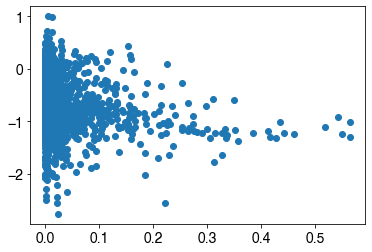

In [139]:
plt.scatter(crop_ha_regrid_15_1d,yearly_tran_grow_bias_mean_1d)

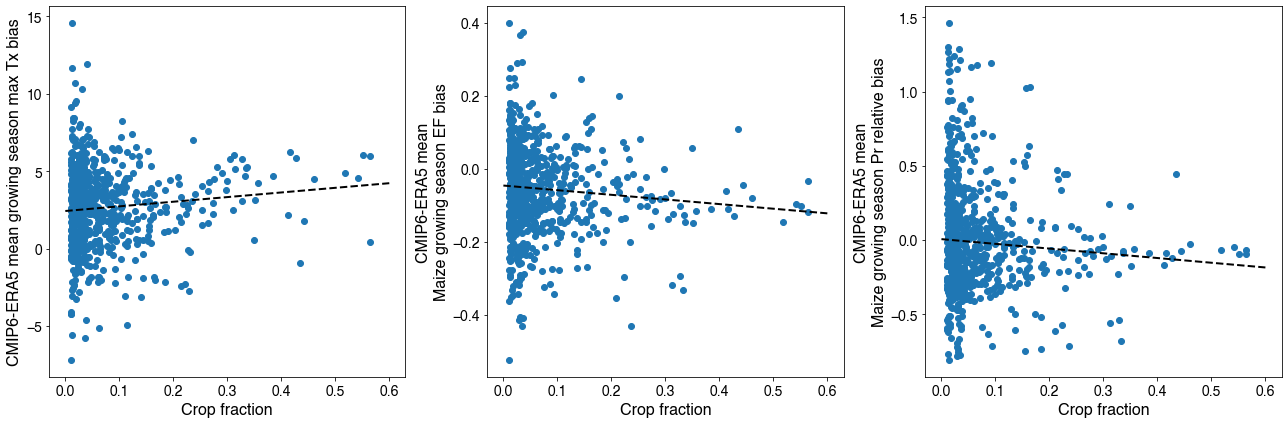

In [131]:

ha_frac_lim_1 = .01
ha_frac_lim_2 = 0.6

nn_tasmax_grow_max = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_ha_regrid_15_1d >= ha_frac_lim_1) & (crop_ha_regrid_15_1d <= ha_frac_lim_2))[0]

X = sm.add_constant(crop_ha_regrid_15_1d[nn_tasmax_grow_max])
mdl_tasmax_grow_max_bias_mean = sm.RLM(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max], X).fit()

nn_ef_grow = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_ef_grow_bias_mean_1d)) & (crop_ha_regrid_15_1d >= ha_frac_lim_1) & (crop_ha_regrid_15_1d <= ha_frac_lim_2))[0]
X = sm.add_constant(crop_ha_regrid_15_1d[nn_ef_grow])
mdl_ef_grow_mean_bias = sm.RLM(yearly_ef_grow_bias_mean_1d[nn_ef_grow], X).fit()

nn_pr_grow = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_pr_grow_bias_rel_mean_1d)) & (yearly_pr_grow_bias_rel_mean_1d < 1.5) & (crop_ha_regrid_15_1d >= ha_frac_lim_1) & (crop_ha_regrid_15_1d <= ha_frac_lim_2))[0]
X = sm.add_constant(crop_ha_regrid_15_1d[nn_pr_grow])
mdl_pr_grow_mean_bias = sm.RLM(yearly_pr_grow_bias_rel_mean_1d[nn_pr_grow], X).fit()


fig, ax = plt.subplots(1,3,figsize=(18,6))

# x1 = 0
# x2 = 1
# ax[0].scatter(crop_ha_regrid_15_1d[nn_tasmax_grow_max], yearly_tasmax_grow_max_bias_trend_mean_1d[nn_tasmax_grow_max])
# ax[0].plot([x1, x2], [mdl_tasmax_grow_max_bias_trend.params[0]+x1*mdl_tasmax_grow_max_bias_trend.params[1], \
#                     mdl_tasmax_grow_max_bias_trend.params[0]+x2*mdl_tasmax_grow_max_bias_trend.params[1]], '--k', lw=2)
# ax[0].set_xlabel('Crop fraction')
# ax[0].set_ylabel('CMIP6-ERA5 trend in\nMaize growing season max Tx bias')

x1 = 0
x2 = .6
ax[0].scatter(crop_ha_regrid_15_1d[nn_tasmax_grow_max], yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max])
ax[0].plot([x1, x2], [mdl_tasmax_grow_max_bias_mean.params[0]+x1*mdl_tasmax_grow_max_bias_mean.params[1], \
                    mdl_tasmax_grow_max_bias_mean.params[0]+x2*mdl_tasmax_grow_max_bias_mean.params[1]], '--k', lw=2)
ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('CMIP6-ERA5 mean growing season max Tx bias')

# x1 = 0
# x2 = 1
# ax[2].scatter(crop_ha_regrid_15_1d[nn_tasmax_grow_max], cmip6_era5_tasmax_grow_max_trend_bias_mean_1d[nn_tasmax_grow_max])
# ax[2].plot([x1, x2], [mdl_tasmax_grow_max_trend_bias.params[0]+x1*mdl_tasmax_grow_max_trend_bias.params[1], \
#                     mdl_tasmax_grow_max_trend_bias.params[0]+x2*mdl_tasmax_grow_max_trend_bias.params[1]], '--k', lw=2)
# ax[2].set_xlabel('Crop fraction')
# ax[2].set_ylabel('CMIP6-ERA5 mean\nMaize growing season max Tx trend bias')

x1 = 0
x2 = .6
ax[1].scatter(crop_ha_regrid_15_1d[nn_ef_grow], yearly_ef_grow_bias_mean_1d[nn_ef_grow])
ax[1].plot([x1, x2], [mdl_ef_grow_mean_bias.params[0]+x1*mdl_ef_grow_mean_bias.params[1], \
                    mdl_ef_grow_mean_bias.params[0]+x2*mdl_ef_grow_mean_bias.params[1]], '--k', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].set_ylabel('CMIP6-ERA5 mean\nMaize growing season EF bias')

x1 = 0
x2 = .6
ax[2].scatter(crop_ha_regrid_15_1d[nn_pr_grow], yearly_pr_grow_bias_rel_mean_1d[nn_pr_grow])
ax[2].plot([x1, x2], [mdl_pr_grow_mean_bias.params[0]+x1*mdl_pr_grow_mean_bias.params[1], \
                    mdl_pr_grow_mean_bias.params[0]+x2*mdl_pr_grow_mean_bias.params[1]], '--k', lw=2)
ax[2].set_xlabel('Crop fraction')
ax[2].set_ylabel('CMIP6-ERA5 mean\nMaize growing season Pr relative bias')


plt.tight_layout()

access-cm2		Mean: 6.79, p = 0.00
access-esm1-5		Mean: 7.41, p = 0.00
awi-cm-1-1-mr		Mean: 5.27, p = 0.00
bcc-csm2-mr		Mean: 9.85, p = 0.00
bcc-esm1		Mean: 6.13, p = 0.00
canesm5		Mean: 3.28, p = 0.04
ec-earth3		Mean: -2.56, p = 0.00
gfdl-cm4		Mean: -3.16, p = 0.00
gfdl-esm4		Mean: -3.12, p = 0.01
giss-e2-1-g		Mean: -2.77, p = 0.04
kace-1-0-g		Mean: 11.30, p = 0.00
fgoals-g3		Mean: 3.06, p = 0.01
inm-cm5-0		Mean: 11.24, p = 0.00
ipsl-cm6a-lr		Mean: 6.39, p = 0.00
miroc6		Mean: -4.52, p = 0.04
mpi-esm1-2-hr		Mean: 1.12, p = 0.32
mpi-esm1-2-lr		Mean: -1.83, p = 0.19
mri-esm2-0		Mean: -1.46, p = 0.25
noresm2-lm		Mean: 8.24, p = 0.00
noresm2-mm		Mean: 9.03, p = 0.00

12 5 3


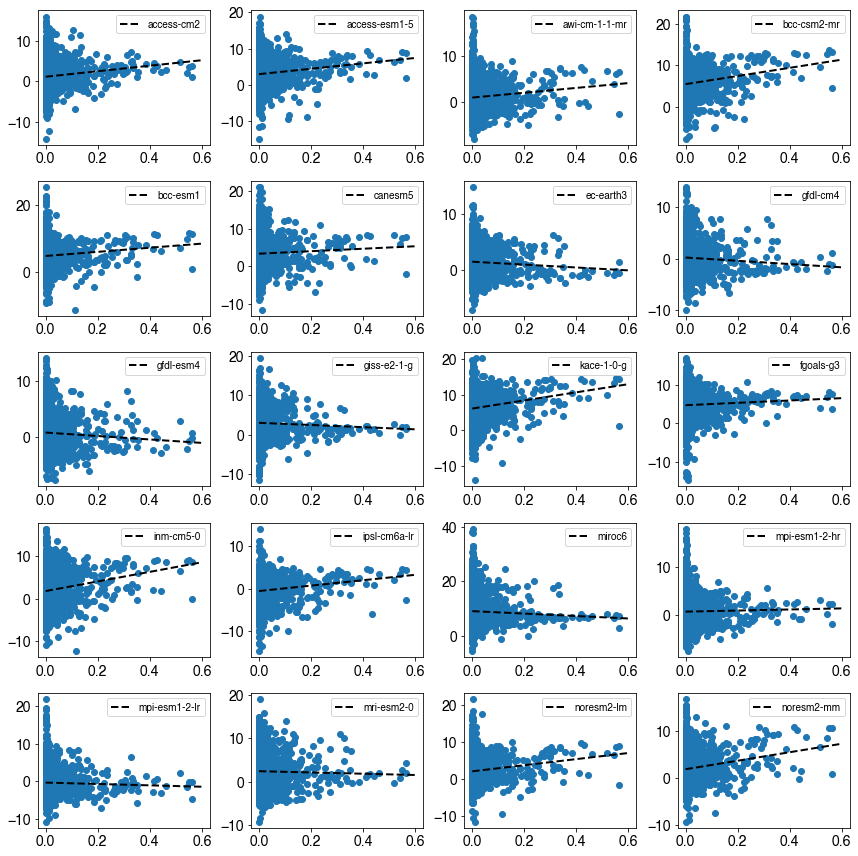

In [132]:
ha_frac_lim_1 = 0
ha_frac_lim_2 = 1

n_pos_sig_mean = 0
n_neg_sig_mean = 0
n_nonsig_mean = 0


fig, ax = plt.subplots(5,4,figsize=(12,12))

m = 0
for x in range(5):
    for y in range(4):
    
        if m >= yearly_tasmax_grow_max_bias.shape[0]:
            break
            
        yearly_tasmax_grow_max_bias_mean_1d = np.reshape(np.nanmean(yearly_tasmax_grow_max_bias[m,:,:,:], axis=0), [yearly_tasmax_grow_max_bias[m,0,:,:].size, 1])
        nn = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_ha_regrid_15_1d >= ha_frac_lim_1) & (crop_ha_regrid_15_1d <= ha_frac_lim_2))[0]

        X = sm.add_constant(crop_ha_regrid_15_1d[nn])
        mdl_mean = sm.RLM(yearly_tasmax_grow_max_bias_mean_1d[nn], X).fit()

        if mdl_mean.params[1] > 0 and mdl_mean.pvalues[1] <= 0.05:
            n_pos_sig_mean += 1
        elif mdl_mean.params[1] < 0 and mdl_mean.pvalues[1] <= 0.05:
            n_neg_sig_mean += 1
        else:
            n_nonsig_mean += 1

        x1 = 0
        x2 = 0.6
        ax[x,y].scatter(crop_ha_regrid_15_1d[nn], yearly_tasmax_grow_max_bias_mean_1d[nn])
        ax[x,y].plot([x1, x2], [mdl_mean.params[0]+x1*mdl_mean.params[1], \
                        mdl_mean.params[0]+x2*mdl_mean.params[1]], '--k', lw=2, label=cmip6_models[m])
        ax[x,y].legend()

        print('%s\t\tMean: %.2f, p = %.2f'%(cmip6_models[m], mdl_mean.params[1], mdl_mean.pvalues[1]))
        m += 1
    
plt.tight_layout()
print()
print(n_pos_sig_mean, n_neg_sig_mean, n_nonsig_mean)


access-cm2		Mean: -0.26, p = 0.19
access-esm1-5		Mean: -0.40, p = 0.02
bcc-esm1		Mean: -0.33, p = 0.16
canesm5		Mean: -0.76, p = 0.00
ec-earth3		Mean: -0.01, p = 0.94
gfdl-esm4		Mean: -0.27, p = 0.14
kace-1-0-g		Mean: -0.56, p = 0.00
fgoals-g3		Mean: -0.22, p = 0.24
inm-cm5-0		Mean: -0.51, p = 0.01
ipsl-cm6a-lr		Mean: -0.32, p = 0.09
miroc6		Mean: -0.56, p = 0.01
mpi-esm1-2-hr		Mean: 0.03, p = 0.79
mpi-esm1-2-lr		Mean: 0.33, p = 0.05
mri-esm2-0		Mean: -0.01, p = 0.93
noresm2-lm		Mean: -0.23, p = 0.20

0 5 10


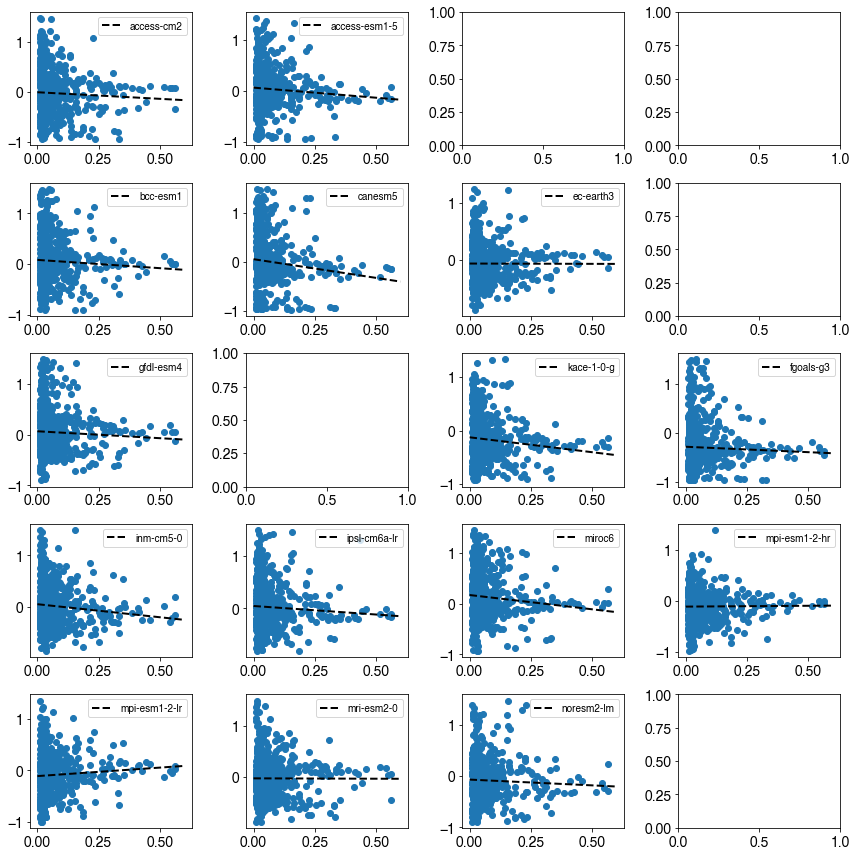

In [133]:
ha_frac_lim_1 = .01
ha_frac_lim_2 = .6

n_pos_sig_mean = 0
n_neg_sig_mean = 0
n_nonsig_mean = 0


fig, ax = plt.subplots(5,4,figsize=(12,12))

m = 0
for x in range(5):
    for y in range(4):
    
        if m >= yearly_tasmax_grow_max_bias.shape[0]:
            break
            
        yearly_pr_grow_bias_rel_cur_model_1d = np.reshape(np.nanmean(yearly_pr_grow_bias_rel[m,:,:,:], axis=0), [yearly_pr_grow_bias_rel[m,0,:,:].size, 1])
        nn = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_pr_grow_bias_rel_cur_model_1d)) & (yearly_pr_grow_bias_rel_cur_model_1d < 1.5) & (crop_ha_regrid_15_1d >= ha_frac_lim_1) & (crop_ha_regrid_15_1d <= ha_frac_lim_2))[0]

        if len(nn) > 0:
            X = sm.add_constant(crop_ha_regrid_15_1d[nn])
            mdl_mean = sm.RLM(yearly_pr_grow_bias_rel_cur_model_1d[nn], X).fit()

            if mdl_mean.params[1] > 0 and mdl_mean.pvalues[1] <= 0.05:
                n_pos_sig_mean += 1
            elif mdl_mean.params[1] < 0 and mdl_mean.pvalues[1] <= 0.05:
                n_neg_sig_mean += 1
            else:
                n_nonsig_mean += 1

            x1 = 0
            x2 = 0.6
            ax[x,y].scatter(crop_ha_regrid_15_1d[nn], yearly_pr_grow_bias_rel_cur_model_1d[nn])
            ax[x,y].plot([x1, x2], [mdl_mean.params[0]+x1*mdl_mean.params[1], \
                            mdl_mean.params[0]+x2*mdl_mean.params[1]], '--k', lw=2, label=cmip6_models[m])
            ax[x,y].legend()

            print('%s\t\tMean: %.2f, p = %.2f'%(cmip6_models[m], mdl_mean.params[1], mdl_mean.pvalues[1]))
        m += 1
    
plt.tight_layout()
print()
print(n_pos_sig_mean, n_neg_sig_mean, n_nonsig_mean)


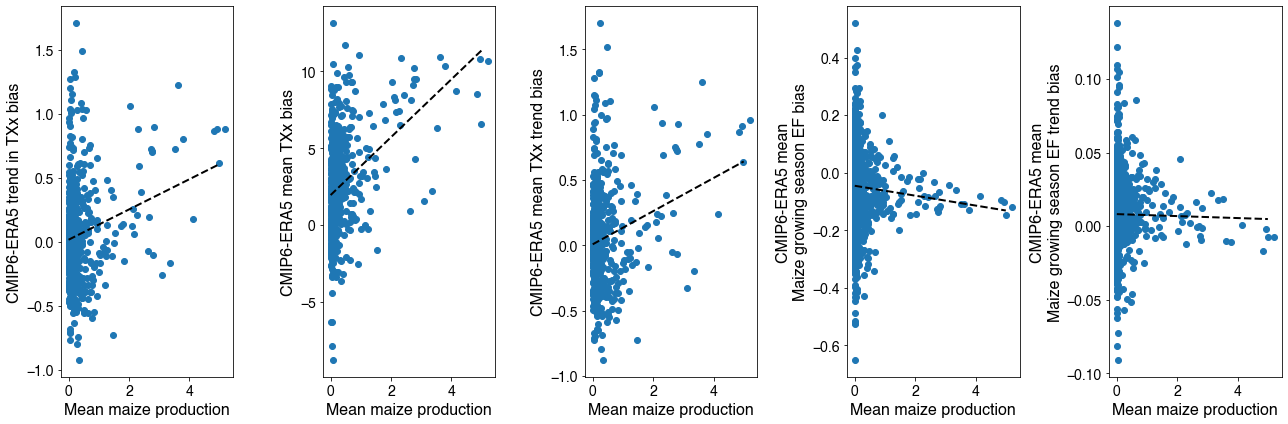

In [134]:
nn_tasmax_grow_max = np.where((~np.isnan(prod_trend_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_ha_regrid_15_1d>.01) & (crop_ha_regrid_15_1d<=1))[0]

X = sm.add_constant(prod_mean_1d[nn_tasmax_grow_max])
mdl_tasmax_grow_max_bias_trend = sm.RLM(yearly_tasmax_grow_max_bias_trend_mean_1d[nn_tasmax_grow_max], X).fit()

X = sm.add_constant(prod_mean_1d[nn_tasmax_grow_max])
mdl_tasmax_grow_max_bias_mean = sm.RLM(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max], X).fit()

X = sm.add_constant(prod_mean_1d[nn_tasmax_grow_max])
mdl_tasmax_grow_max_trend_bias = sm.RLM(cmip6_era5_tasmax_grow_max_trend_bias_mean_1d[nn_tasmax_grow_max], X).fit()

nn_ef_grow = np.where((~np.isnan(prod_mean_1d)) & (~np.isnan(yearly_ef_grow_bias_mean_1d)))[0]
X = sm.add_constant(prod_mean_1d[nn_ef_grow])
mdl_ef_grow_mean_bias = sm.RLM(yearly_ef_grow_bias_mean_1d[nn_ef_grow], X).fit()

nn_ef_grow = np.where((~np.isnan(prod_mean_1d)) & (~np.isnan(cmip6_era5_ef_grow_trend_bias_mean_1d)))[0]
X = sm.add_constant(prod_mean_1d[nn_ef_grow])
mdl_ef_grow_trend_bias = sm.RLM(cmip6_era5_ef_grow_trend_bias_mean_1d[nn_ef_grow], X).fit()

fig, ax = plt.subplots(1,5,figsize=(18,6))

x1 = 0
x2 = 5
ax[0].scatter(prod_mean_1d[nn_tasmax_grow_max], yearly_tasmax_grow_max_bias_trend_mean_1d[nn_tasmax_grow_max])
ax[0].plot([x1, x2], [mdl_tasmax_grow_max_bias_trend.params[0]+x1*mdl_tasmax_grow_max_bias_trend.params[1], \
                    mdl_tasmax_grow_max_bias_trend.params[0]+x2*mdl_tasmax_grow_max_bias_trend.params[1]], '--k', lw=2)
ax[0].set_xlabel('Mean maize production')
ax[0].set_ylabel('CMIP6-ERA5 trend in TXx bias')

ax[1].scatter(prod_mean_1d[nn_tasmax_grow_max], yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max])
ax[1].plot([x1, x2], [mdl_tasmax_grow_max_bias_mean.params[0]+x1*mdl_tasmax_grow_max_bias_mean.params[1], \
                    mdl_tasmax_grow_max_bias_mean.params[0]+x2*mdl_tasmax_grow_max_bias_mean.params[1]], '--k', lw=2)
ax[1].set_xlabel('Mean maize production')
ax[1].set_ylabel('CMIP6-ERA5 mean TXx bias')


ax[2].scatter(prod_mean_1d[nn_tasmax_grow_max], cmip6_era5_tasmax_grow_max_trend_bias_mean_1d[nn_tasmax_grow_max])
ax[2].plot([x1, x2], [mdl_tasmax_grow_max_trend_bias.params[0]+x1*mdl_tasmax_grow_max_trend_bias.params[1], \
                    mdl_tasmax_grow_max_trend_bias.params[0]+x2*mdl_tasmax_grow_max_trend_bias.params[1]], '--k', lw=2)
ax[2].set_xlabel('Mean maize production')
ax[2].set_ylabel('CMIP6-ERA5 mean TXx trend bias')

ax[3].scatter(prod_mean_1d[nn_ef_grow], yearly_ef_grow_bias_mean_1d[nn_ef_grow])
ax[3].plot([x1, x2], [mdl_ef_grow_mean_bias.params[0]+x1*mdl_ef_grow_mean_bias.params[1], \
                    mdl_ef_grow_mean_bias.params[0]+x2*mdl_ef_grow_mean_bias.params[1]], '--k', lw=2)
ax[3].set_xlabel('Mean maize production')
ax[3].set_ylabel('CMIP6-ERA5 mean\nMaize growing season EF bias')

ax[4].scatter(prod_mean_1d[nn_ef_grow], cmip6_era5_ef_grow_trend_bias_mean_1d[nn_ef_grow])
ax[4].plot([x1, x2], [mdl_ef_grow_trend_bias.params[0]+x1*mdl_ef_grow_trend_bias.params[1], \
                    mdl_ef_grow_trend_bias.params[0]+x2*mdl_ef_grow_trend_bias.params[1]], '--k', lw=2)
ax[4].set_xlabel('Mean maize production')
ax[4].set_ylabel('CMIP6-ERA5 mean\nMaize growing season EF trend bias')


plt.tight_layout()

Text(0.5, 1.0, 'U.S. Midwest (35-45N, 250-275W)')

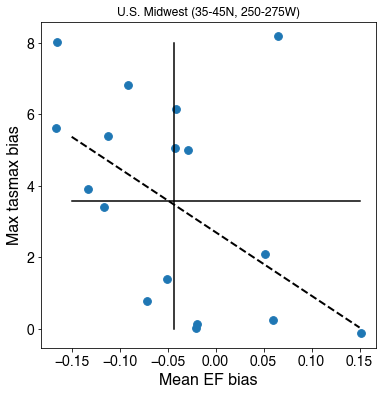

In [135]:
lat_midwest = np.where((regridMesh.lat > 35) & (regridMesh.lat < 45))[0]
lon_midwest = np.where((regridMesh.lon > 250) & (regridMesh.lon < 275))[0]

tasmax_max_bias_midwest = np.nanmean(np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias[:,:,lat_midwest,:][:,:,:,lon_midwest], axis=3), axis=2), axis=1)
ef_mean_bias_midwest = np.nanmean(np.nanmean(np.nanmean(yearly_ef_grow_bias[:,:,lat_midwest,:][:,:,:,lon_midwest], axis=3), axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_midwest) & ~np.isnan(ef_mean_bias_midwest))[0]
X = sm.add_constant(ef_mean_bias_midwest[nn])
mdl = sm.RLM(tasmax_max_bias_midwest[nn], X).fit()

x1 = -.15
x2 = .15
plt.figure(figsize=(6,6))

plt.plot([np.nanmean(ef_mean_bias_midwest), np.nanmean(ef_mean_bias_midwest)], [0,8], '-k')
plt.plot([-.15, .15], [np.nanmean(tasmax_max_bias_midwest), np.nanmean(tasmax_max_bias_midwest)], '-k')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.scatter(ef_mean_bias_midwest,tasmax_max_bias_midwest, s=60)
plt.xlabel('Mean EF bias')
plt.ylabel('Max tasmax bias')
plt.title('U.S. Midwest (35-45N, 250-275W)')


Text(0.5, 1.0, 'Global cropland (fraction > 0.25)')

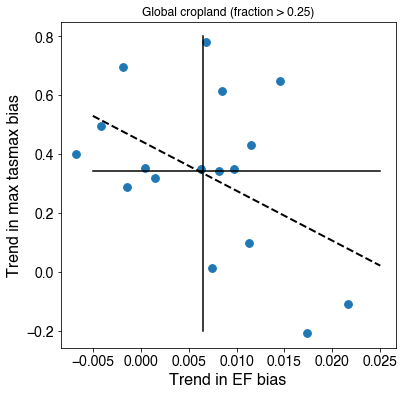

In [136]:

nn_cropland = np.where((crop_ha_regrid_15_1d>0.25))[0]

tasmax_max_bias_trend_global_crop_1d = yearly_tasmax_grow_max_bias_trend.reshape([yearly_tasmax_grow_max_bias_trend.shape[0], \
                                                                  yearly_tasmax_grow_max_bias_trend.shape[1]*yearly_tasmax_grow_max_bias_trend.shape[2]])
tasmax_max_bias_trend_global_crop_1d = np.nanmean(tasmax_max_bias_trend_global_crop_1d[:, nn_cropland], axis=1)

ef_mean_bias_trend_global_crop_1d = yearly_ef_grow_bias_trend.reshape([yearly_ef_grow_bias_trend.shape[0], \
                                                                  yearly_ef_grow_bias_trend.shape[1]*yearly_ef_grow_bias_trend.shape[2]])
ef_mean_bias_trend_global_crop_1d = np.nanmean(ef_mean_bias_trend_global_crop_1d[:, nn_cropland], axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_trend_global_crop_1d) & ~np.isnan(ef_mean_bias_trend_global_crop_1d))[0]
X = sm.add_constant(ef_mean_bias_trend_global_crop_1d[nn])
mdl = sm.RLM(tasmax_max_bias_trend_global_crop_1d[nn], X).fit()

x1 = -.005
x2 = .025
plt.figure(figsize=(6,6))

plt.plot([np.nanmean(ef_mean_bias_trend_global_crop_1d), np.nanmean(ef_mean_bias_trend_global_crop_1d)], [-.2, .8], '-k')
plt.plot([x1, x2], [np.nanmean(tasmax_max_bias_trend_global_crop_1d), np.nanmean(tasmax_max_bias_trend_global_crop_1d)], '-k')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.scatter(ef_mean_bias_trend_global_crop_1d, tasmax_max_bias_trend_global_crop_1d, s=60)

plt.xlabel('Trend in EF bias')
plt.ylabel('Trend in max tasmax bias')
plt.title('Global cropland (fraction > 0.25)')


In [137]:
cmip6_ha_bias_global_grop_1d = cmip6_ha_bias.reshape([cmip6_ha_bias.shape[0], cmip6_ha_bias.shape[1]*cmip6_ha_bias.shape[2]])

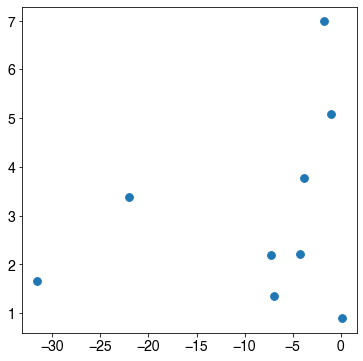

In [138]:
# cmip6_ha_bias

nn_cropland = np.where((crop_all_ha_regrid_15_1d>.25))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                  yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

cmip6_ha_bias_global_grop_1d = cmip6_ha_bias.reshape([cmip6_ha_bias.shape[0], cmip6_ha_bias.shape[1]*cmip6_ha_bias.shape[2]])
cmip6_ha_bias_global_grop_1d = np.nanmean(cmip6_ha_bias_global_grop_1d[:, nn_cropland], axis=1)


nn = np.where((~np.isnan(cmip6_ha_bias_global_grop_1d)) & (~np.isnan(tasmax_max_bias_global_crop_1d)))[0]
X = sm.add_constant(cmip6_ha_bias_global_grop_1d[nn])
mdl = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()

x1 = -.25
x2 = .05
plt.figure(figsize=(6,6))

# plt.plot([np.nanmean(pr_grow_rel_bias_global_crop_1d), np.nanmean(pr_grow_rel_bias_global_crop_1d)], [0,8], '-k')
# plt.plot([x1, x2], [np.nanmean(pr_grow_rel_bias_global_crop_1d), np.nanmean(pr_grow_rel_bias_global_crop_1d)], '-k')
# plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
#                     mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.scatter(cmip6_ha_bias_global_grop_1d, tasmax_max_bias_global_crop_1d, s=60)
# plt.xlabel('Mean EF bias')
# plt.ylabel('Mean relative precip bias')
# plt.title('Global cropland (fraction > 0.25)')



Text(0.5, 1.0, 'Global cropland (fraction > 0.25)')

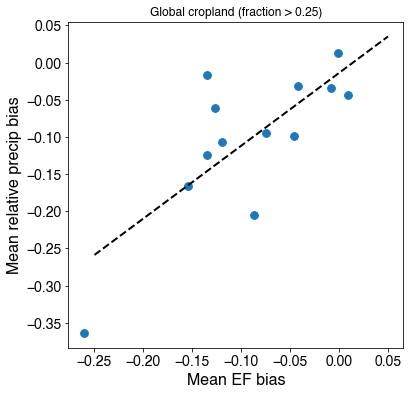

In [139]:

nn_cropland = np.where((crop_ha_regrid_15_1d>.25))[0]

pr_grow_rel_bias_global_crop_1d = yearly_pr_grow_bias_rel.reshape([yearly_pr_grow_bias_rel.shape[0], yearly_pr_grow_bias_rel.shape[1], \
                                                                  yearly_pr_grow_bias_rel.shape[2]*yearly_pr_grow_bias_rel.shape[3]])
pr_grow_rel_bias_global_crop_1d = np.nanmean(np.nanmean(pr_grow_rel_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
pr_grow_rel_bias_global_crop_1d[pr_grow_rel_bias_global_crop_1d>2] = np.nan
ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                  yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(ef_mean_bias_global_crop_1d) & ~np.isnan(pr_grow_rel_bias_global_crop_1d))[0]
X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
mdl = sm.RLM(pr_grow_rel_bias_global_crop_1d[nn], X).fit()

x1 = -.25
x2 = .05
plt.figure(figsize=(6,6))

# plt.plot([np.nanmean(pr_grow_rel_bias_global_crop_1d), np.nanmean(pr_grow_rel_bias_global_crop_1d)], [0,8], '-k')
# plt.plot([x1, x2], [np.nanmean(pr_grow_rel_bias_global_crop_1d), np.nanmean(pr_grow_rel_bias_global_crop_1d)], '-k')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.scatter(ef_mean_bias_global_crop_1d, pr_grow_rel_bias_global_crop_1d, s=60)
plt.xlabel('Mean EF bias')
plt.ylabel('Mean relative precip bias')
plt.title('Global cropland (fraction > 0.25)')


Text(0.5, 1.0, 'Global cropland (fraction > 0.25)')

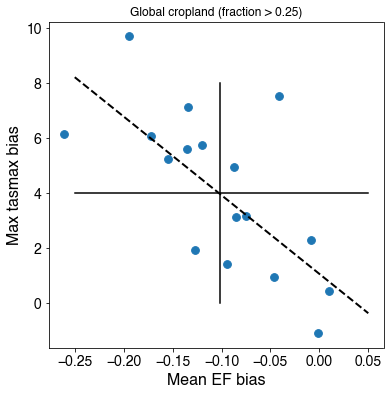

In [140]:

nn_cropland = np.where((crop_ha_regrid_15_1d>0.25))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                  yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                  yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(ef_mean_bias_global_crop_1d))[0]
X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
mdl = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()

x1 = -.25
x2 = .05
plt.figure(figsize=(6,6))

plt.plot([np.nanmean(ef_mean_bias_global_crop_1d), np.nanmean(ef_mean_bias_global_crop_1d)], [0,8], '-k')
plt.plot([x1, x2], [np.nanmean(tasmax_max_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d)], '-k')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.scatter(ef_mean_bias_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60)
plt.xlabel('Mean EF bias')
plt.ylabel('Max tasmax bias')
plt.title('Global cropland (fraction > 0.25)')


Text(0.5, 1.0, 'Global cropland (fraction > 0.25)')

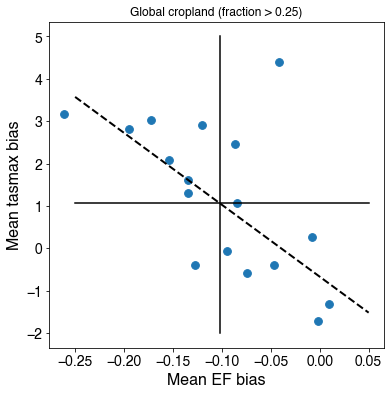

In [141]:

nn_cropland = np.where((crop_ha_regrid_15_1d>0.25))[0]

tasmax_mean_bias_global_crop_1d = yearly_tasmax_grow_mean_bias.reshape([yearly_tasmax_grow_mean_bias.shape[0], yearly_tasmax_grow_mean_bias.shape[1], \
                                                                  yearly_tasmax_grow_mean_bias.shape[2]*yearly_tasmax_grow_mean_bias.shape[3]])
tasmax_mean_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                  yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_mean_bias_global_crop_1d) & ~np.isnan(ef_mean_bias_global_crop_1d))[0]
X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
mdl = sm.RLM(tasmax_mean_bias_global_crop_1d[nn], X).fit()

x1 = -.25
x2 = .05
plt.figure(figsize=(6,6))

plt.plot([np.nanmean(ef_mean_bias_global_crop_1d), np.nanmean(ef_mean_bias_global_crop_1d)], [-2,5], '-k')
plt.plot([x1, x2], [np.nanmean(tasmax_mean_bias_global_crop_1d), np.nanmean(tasmax_mean_bias_global_crop_1d)], '-k')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.scatter(ef_mean_bias_global_crop_1d, tasmax_mean_bias_global_crop_1d, s=60)
plt.xlabel('Mean EF bias')
plt.ylabel('Mean tasmax bias')
plt.title('Global cropland (fraction > 0.25)')


Text(0.5, 1.0, 'Global cropland (varied fractions)')

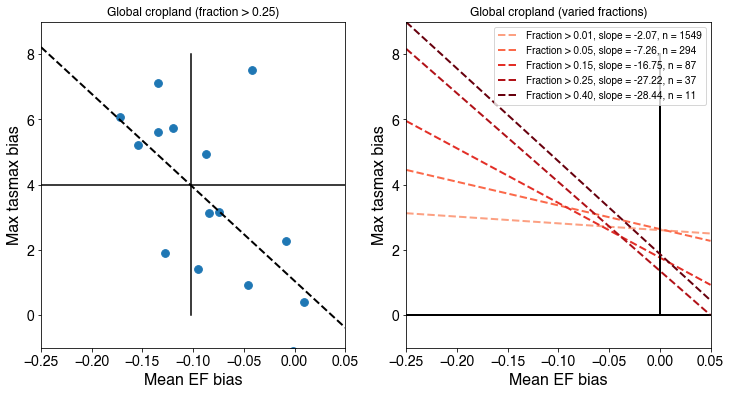

In [142]:

x1 = -.25
x2 = .05
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].set_xlim([-.25, .05])
ax[0].set_ylim([-1, 9])


nn_cropland = np.where((crop_ha_regrid_15_1d > 0.25))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                  yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                  yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(ef_mean_bias_global_crop_1d))[0]
X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
mdl = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()


ax[0].plot([np.nanmean(ef_mean_bias_global_crop_1d), np.nanmean(ef_mean_bias_global_crop_1d)], [0,8], '-k')
ax[0].plot([x1, x2], [np.nanmean(tasmax_max_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d)], '-k')
ax[0].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--', lw=2, color='k')
ax[0].scatter(ef_mean_bias_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60)
ax[0].set_xlabel('Mean EF bias')
ax[0].set_ylabel('Max tasmax bias')
ax[0].set_title('Global cropland (fraction > 0.25)')

ax[1].set_xlim([-.25, .05])
ax[1].set_ylim([-1, 9])

cmap = plt.get_cmap('Reds')
lims = [0, .01, .05, .15, .25, .4]

for i, lim in enumerate(lims):
    if i == 0:
        nn_cropland = np.where((np.isnan(crop_ha_regrid_15_1d)))[0]
        continue
    elif i == 1:
        nn_cropland = np.where((crop_ha_regrid_15_1d<=lim))[0]
    else:
        nn_cropland = np.where((crop_ha_regrid_15_1d>lim))[0]

    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                      yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
    ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


    nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(ef_mean_bias_global_crop_1d))[0]
    X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
    mdl = sm.OLS(tasmax_max_bias_global_crop_1d[nn], X).fit()

#     ax[1].scatter(ef_mean_bias_global_crop_1d, tasmax_max_bias_global_crop_1d, s=20, c=colors[i])
    ax[1].plot([0, 0], [0,8], '-k')
    ax[1].plot([x1, x2], [0, 0], '-k')
    
    if i == 0:
        label = 'Fraction < %.2f, slope = %.2f, n = %d'%(lim, mdl.params[1], len(nn_cropland))
    else:
        label = 'Fraction > %.2f, slope = %.2f, n = %d'%(lim, mdl.params[1], len(nn_cropland))
    
    ax[1].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                        mdl.params[0]+x2*mdl.params[1]], '--', lw=2, color=cmap(((i+1)/len(lims))), label=label)

ax[1].legend(loc='upper right')
# plt.scatter(ef_mean_bias_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60)
plt.xlabel('Mean EF bias')
plt.ylabel('Max tasmax bias')
plt.title('Global cropland (varied fractions)')


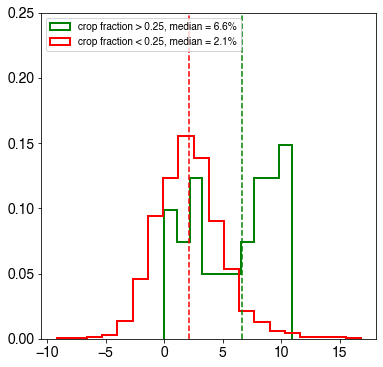

In [144]:
nn_tasmax_grow_max_crop = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_ha_regrid_15_1d>.25) & (crop_ha_regrid_15_1d<=1))[0]
nn_tasmax_grow_max_nocrop = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_ha_regrid_15_1d <=.25))[0]

plt.figure(figsize=(6,6))
plt.ylim([0, .25])
histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_crop], bins=10, density=True, histtype='step', color='g', lw=2, \
                                                       label='crop fraction > 0.25, median = %0.1f%%'%np.nanmedian(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_crop]))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_nocrop], bins=20, density=True, histtype='step', color='r', lw=2, \
                                                             label='crop fraction < 0.25, median = %0.1f%%'%np.nanmedian(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_nocrop]))

plt.plot([np.nanmedian(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_nocrop]), np.nanmedian(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_nocrop])], [0, .25], '--r')
plt.plot([np.nanmedian(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_crop]), np.nanmedian(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_crop])], [0, .25], '--g')
plt.legend()

Text(0.5, 1.0, 'U.S. Midwest (35-45N, 250-275W)')

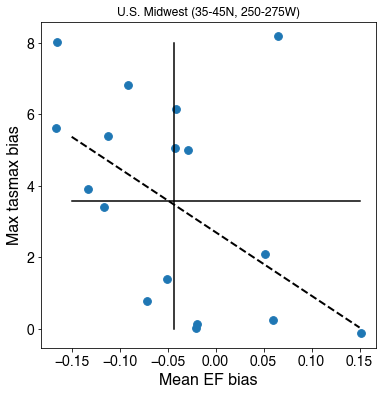

In [145]:
lat_midwest = np.where((regridMesh.lat > 35) & (regridMesh.lat < 45))[0]
lon_midwest = np.where((regridMesh.lon > 250) & (regridMesh.lon < 275))[0]

tasmax_max_bias_midwest = np.nanmean(np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias[:,:,lat_midwest,:][:,:,:,lon_midwest], axis=3), axis=2), axis=1)
ef_mean_bias_midwest = np.nanmean(np.nanmean(np.nanmean(yearly_ef_grow_bias[:,:,lat_midwest,:][:,:,:,lon_midwest], axis=3), axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_midwest) & ~np.isnan(ef_mean_bias_midwest))[0]
X = sm.add_constant(ef_mean_bias_midwest[nn])
mdl = sm.RLM(tasmax_max_bias_midwest[nn], X).fit()

x1 = -.15
x2 = .15
plt.figure(figsize=(6,6))

plt.plot([np.nanmean(ef_mean_bias_midwest), np.nanmean(ef_mean_bias_midwest)], [0,8], '-k')
plt.plot([-.15, .15], [np.nanmean(tasmax_max_bias_midwest), np.nanmean(tasmax_max_bias_midwest)], '-k')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.scatter(ef_mean_bias_midwest,tasmax_max_bias_midwest, s=60)
plt.xlabel('Mean EF bias')
plt.ylabel('Max tasmax bias')
plt.title('U.S. Midwest (35-45N, 250-275W)')
